In [1]:
%matplotlib inline
import numpy as np
import pyfits as pf
import matplotlib.pyplot as pl

from xd import XDGMM, xd_model
from utils import load_xd_parms
from demo_utils import fake_data_plot 

import warnings
warnings.filterwarnings('ignore')

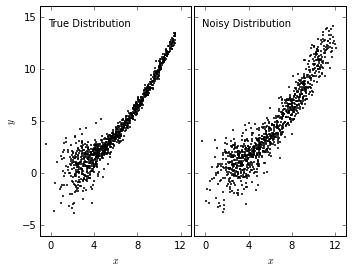

In [2]:
def generate_fake_data(N=1000, seed=1234):
    """
    Generate a set of fake data for demo purposes.
    """
    # generate the true data
    x_true = (1.4 + 2 * np.random.random(N)) ** 2
    y_true = 0.1 * x_true ** 2

    # add scatter to "true" distribution
    dx = 0.1 + 4. / x_true ** 2
    dy = 0.1 + 10. / x_true ** 2
    x_true += np.random.normal(0, dx, N)
    y_true += np.random.normal(0, dy, N)

    # add noise to get the "observed" distribution
    dx = 0.2 + 0.5 * np.random.random(N)
    dy = 0.2 + 0.5 * np.random.random(N)

    x = x_true + np.random.normal(0, dx)
    y = y_true + np.random.normal(0, dy)

    # stack the results for computation
    X = np.vstack([x, y]).T
    Xcov = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    Xcov[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T
    
    # show the data
    fake_data_plot(x_true, y_true, x, y)
    
    # save it to file
    hdulist = pf.HDUList([pf.PrimaryHDU(X), pf.ImageHDU(Xcov)])
    hdulist.writeto('fake_data.fits', clobber=True)
    
    return X, Xcov, x_true, y_true
    
X, Xcov, x_true, y_true = generate_fake_data()

In [10]:
def run_xd_on_fake(N=1000, n_components=8, datafile='fake_data.fits'):
    """
    Run `Extreme Deconvolution' on generated data.
    """
    batch_size = N
    model = XDGMM(datafile, n_components, batch_size, eta=0.,
                  n_iter=50, Nthreads=2, verbose=True)

run_xd_on_fake()


Initalization done in 0.38 sec
Initial Log Likelihood:  -3.92764787177
Initial Valid Log Likelihood:  -3.92764787177

|  iter   |  train L   |  valid L   | weight  | itr time | tot time |  Nbad   |
-------------------------------------------------------------------------------
|    0    |  -3.9045   |  -3.9045   |    1    |   0.44   |   0.44   |    0    |
|    1    |  -3.8938   |  -3.9045   |    1    |   0.33   |   0.78   |    0    |
|    2    |  -3.8875   |  -3.9045   |    1    |   0.33   |   1.1    |    0    |
|    3    |  -3.8833   |  -3.9045   |    1    |   0.33   |   1.4    |    0    |
|    4    |  -3.8804   |  -3.9045   |    1    |   0.33   |   1.8    |    0    |
|    5    |  -3.8782   |  -3.9045   |    1    |   0.33   |   2.1    |    0    |
|    6    |  -3.8765   |  -3.9045   |    1    |   0.33   |   2.4    |    0    |
|    7    |  -3.8752   |  -3.9045   |    1    |   0.33   |   2.8    |    0    |
|    8    |  -3.8742   |  -3.9045   |    1    |   0.33   |   3.1    |    0    |
|

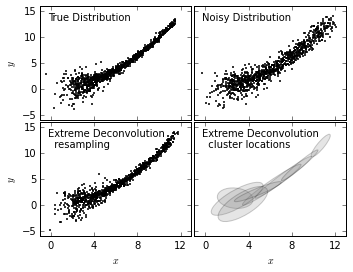

In [11]:
alphas, mus, Vs, logls, _ = load_xd_parms('xd_parms.hdf5')
model = xd_model(alphas.size, X.shape)
model.alpha = alphas
model.mu = mus
model.V = Vs

samples = model.sample(size=1000)

fake_data_plot(x_true, y_true, X[:, 0], X[:, 1], samples, mus, Vs)